###Importing libraries

In [0]:
import requests
import pandas as pd
from io import StringIO

###Setting parameters

In [0]:
symbol = "MSFT"
apikey = "3VABX86SUL1NE9NX"
datatype = "csv"

###API request

In [0]:
url = f"https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY&symbol={symbol}&apikey={apikey}&datatype={datatype}"
r = requests.get(url)
data = pd.read_csv(StringIO(r.text))
print(data.head())

    timestamp     open    high     low   close     volume
0  2025-10-20  514.800  531.03  506.00  516.79  244568363
1  2025-09-30  500.465  519.30  492.37  517.95  423675634
2  2025-08-29  535.000  538.25  498.51  506.69  454910237
3  2025-07-31  496.470  555.45  488.70  533.50  396888800
4  2025-06-30  457.140  500.76  456.89  497.41  401277780


###Transforming the data

In [0]:
# Rename columns (already fine, but standardizing)
data = data.rename(columns={
    'timestamp': 'date',
})

# Convert date to datetime type
data['date'] = pd.to_datetime(data['date'])

# Ensure numeric columns are correct types
numeric_cols = ['open', 'high', 'low', 'close', 'volume']
data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric)

# Sort by date ascending
data = data.sort_values('date')

# Preview transformed data
print(data.head())


          date    open    high    low   close      volume
310 1999-12-31   91.06  119.94  90.87  116.75   630488900
309 2000-01-31  117.37  118.62  94.87   97.87   637437600
308 2000-02-29   98.50  110.00  88.12   89.37   667243800
307 2000-03-31   89.62  115.00  88.94  106.25  1014093800
306 2000-04-28   94.44   96.50  65.00   69.75  1129073300


In [0]:
# Find the latest date in the dataset
latest_date = data['date'].max()
print("Latest date in dataset:", latest_date)


Latest date in dataset: 2025-10-20 00:00:00


###Loading to Spark Dataframe

In [0]:
%sql
use catalog personal_catalog

In [0]:
%sql
create schema MSFT_stock_prices

In [0]:
%sql
use schema MSFT_stock_prices

In [0]:
spark_df = spark.createDataFrame(data)
spark_df.write.mode("overwrite").saveAsTable("personal_catalog.MSFT_stock_prices.MSFTstock_prices")
print(spark_df.head(5))


[Row(date=datetime.datetime(1999, 12, 31, 0, 0), open=91.06, high=119.94, low=90.87, close=116.75, volume=630488900), Row(date=datetime.datetime(2000, 1, 31, 0, 0), open=117.37, high=118.62, low=94.87, close=97.87, volume=637437600), Row(date=datetime.datetime(2000, 2, 29, 0, 0), open=98.5, high=110.0, low=88.12, close=89.37, volume=667243800), Row(date=datetime.datetime(2000, 3, 31, 0, 0), open=89.62, high=115.0, low=88.94, close=106.25, volume=1014093800), Row(date=datetime.datetime(2000, 4, 28, 0, 0), open=94.44, high=96.5, low=65.0, close=69.75, volume=1129073300)]


In [0]:
df = spark.read.table("personal_catalog.MSFT_stock_prices.MSFTstock_prices")
display(df.limit(5))

date,open,high,low,close,volume
1999-12-31T00:00:00.000Z,91.06,119.94,90.87,116.75,630488900
2000-01-31T00:00:00.000Z,117.37,118.62,94.87,97.87,637437600
2000-02-29T00:00:00.000Z,98.5,110.0,88.12,89.37,667243800
2000-03-31T00:00:00.000Z,89.62,115.0,88.94,106.25,1014093800
2000-04-28T00:00:00.000Z,94.44,96.5,65.0,69.75,1129073300


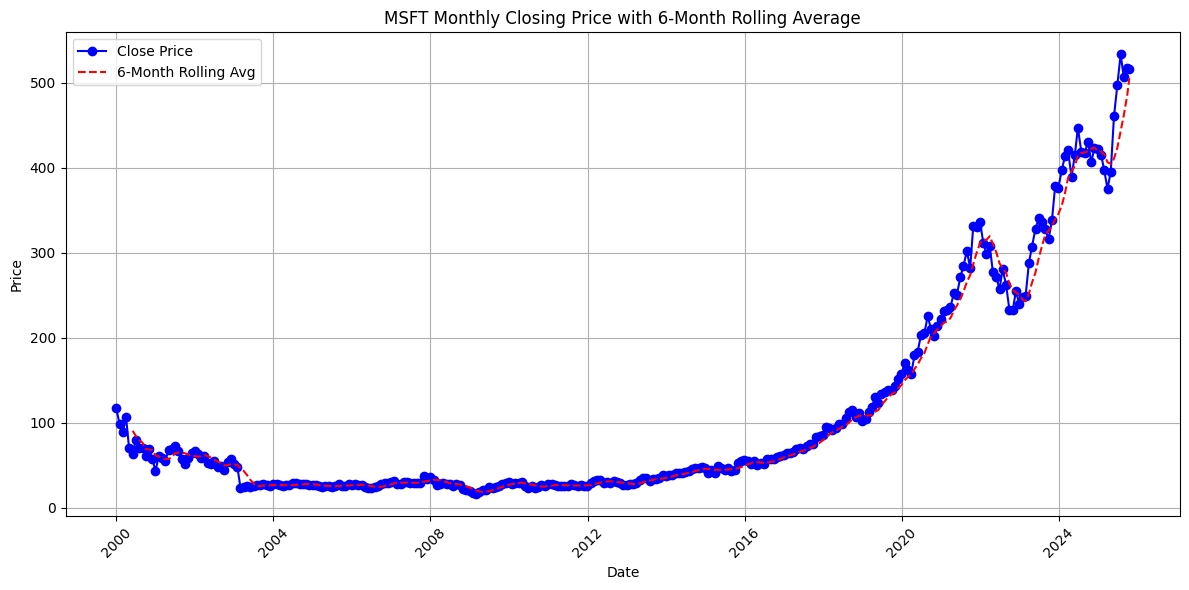

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate 6-month rolling average of closing price
data['rolling_avg_6m'] = data['close'].rolling(window=6).mean()

# Plot original close price and rolling average
plt.figure(figsize=(12,6))
plt.plot(data['date'], data['close'], marker='o', linestyle='-', color='blue', label='Close Price')
plt.plot(data['date'], data['rolling_avg_6m'], linestyle='--', color='red', label='6-Month Rolling Avg')
plt.title(f"{symbol} Monthly Closing Price with 6-Month Rolling Average")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [0]:
import pandas as pd
import plotly.graph_objects as go
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Filter historical data from 2012
historical_data = data[data['date'] >= '2012-01-01'].copy()
ts = historical_data.set_index('date')['close']

# Fit Holt-Winters model with additive trend (no seasonality)
model = ExponentialSmoothing(ts, trend='add', seasonal=None)
fit = model.fit()

# Forecast next 12 months
forecast_12m = fit.forecast(12)
forecast_dates = pd.date_range(historical_data['date'].max() + pd.offsets.MonthEnd(1), periods=12, freq='M')

# Create interactive plot
fig = go.Figure()

# Historical trace
fig.add_trace(go.Scatter(
    x=historical_data['date'],
    y=historical_data['close'],
    mode='lines+markers',
    name='Historical Close',
    line=dict(color='blue'),
    marker=dict(size=6)
))

# Forecast trace
fig.add_trace(go.Scatter(
    x=forecast_dates,
    y=forecast_12m,
    mode='lines+markers',
    name='12-Month Forecast',
    line=dict(color='red', dash='dash'),
    marker=dict(size=6)
))

# Layout
fig.update_layout(
    title=f"{symbol} Historical Close (2012-Present) + 12-Month Forecast",
    xaxis_title="Date",
    yaxis_title="Close Price",
    hovermode="x unified"
)

fig.show()




/databricks/python/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/databricks/python/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/databricks/python/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/home/spark-05516519-3cfa-45ca-9a4b-c4/.ipykernel/2476/command-6989035092460956-2597160249:15: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

